# 1. Imports


1. Verify hd-bet works for PET images (try with and without skull)
     -> If not look at bet2
   
3. Try in Native space rather than MNI space
   
4. Try ADC if available

5. Expand Dataset
   
     -> Check unprocessed data, ADNI data (possibly ADNI for validation later)

6. Read literature and try different architectures
   
    -> Log metrics on test set after each experiment
        (SSIM, MSE, Inception score)

If use department GPU, make sure don't hog resources (esp if running overnight)

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import AHNet
from tqdm import tqdm
import monai
from monai.utils import progress_bar
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    RandFlipd,
    Resized,
    Rotate90d,
    ScaleIntensityd,
    DeleteItemsd,
    NormalizeIntensityd
)
from monai.losses.ssim_loss import SSIMLoss
import statistics

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="5,6,7"

In [3]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

# 2. MONAI Dataloader

In [4]:
#To turn 4D images to 3D (from Ashley's classifier)
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,128,128,64))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,128,128,64))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data

#This uses the mask to scale the intensity of the image (not being used rn)
class ScaleImaged(MapTransform):
    def __call__(self, data):
            data[self.keys[0]] *= (0.4+data[self.keys[1]])

            return data

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["t1", "t1c", "t2", "flair", "pet"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Orientationd(keys=["t1", "t1c", "t2", "flair", "pet"], axcodes="RAS"),        
        EnsureTyped(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Resized(keys=["t1", "t1c", "t2", "flair", "pet"], spatial_size=(128,128,64)),
        MakeSingleVolumed(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Rotate90d(keys=["t1", "t1c", "t2", "flair", "pet"]),
        RandFlipd(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.5, spatial_axis=1),
        RandRotated(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.6, range_z=0.3),
        ScaleIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        NormalizeIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"])
    ]
)

In [6]:
val_files = dictionary_train[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

It has been 15.31666088104248 seconds since the loop started


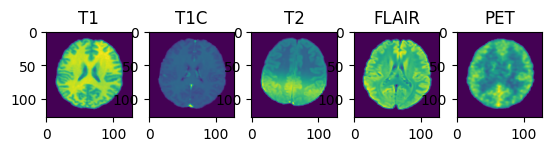

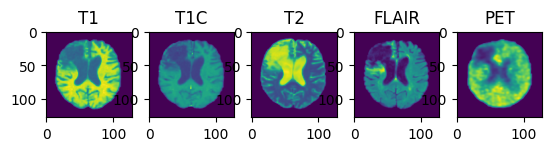

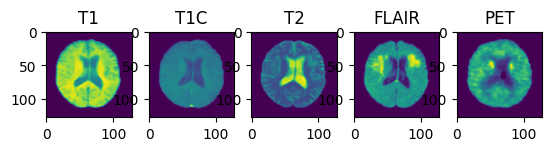

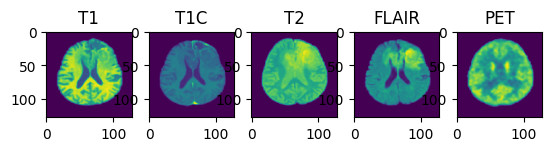

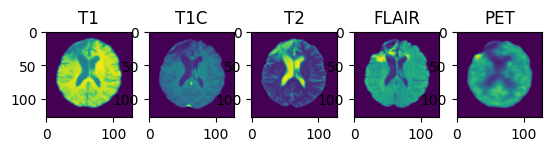

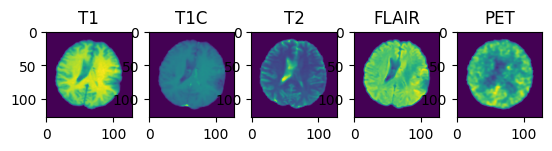

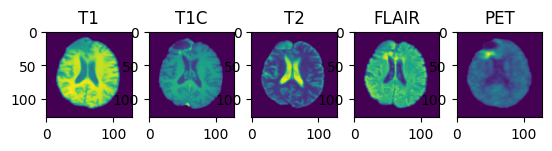

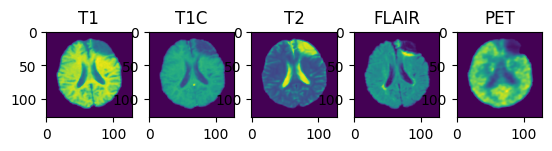

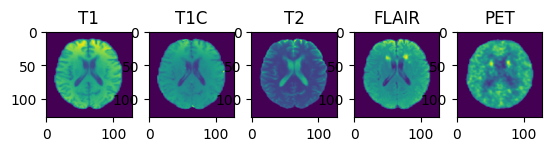

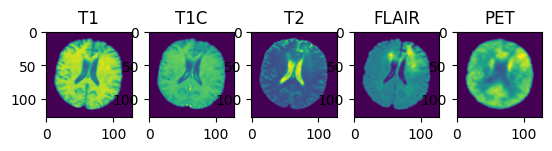

In [7]:
program_starts = time()
step = 1350
slice_index = 32
for item in check_DataLoader:
    image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index]
    
    f, axarr = plt.subplots(1, 5)
    
    axarr[0].imshow(image_datas[0])
    axarr[0].set_title("T1")
    axarr[1].imshow(image_datas[1])
    axarr[1].set_title("T1C")
    axarr[2].imshow(image_datas[2])
    axarr[2].set_title("T2")
    axarr[3].imshow(image_datas[3])
    axarr[3].set_title("FLAIR")
    axarr[4].imshow(image_datas[4])
    axarr[4].set_title("PET")
    
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

In [8]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=os.cpu_count(), drop_last=False)

valid_ds = CacheDataset(data=dictionary_valid, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

80


Loading dataset: 100%|██████████████████████████| 57/57 [00:33<00:00,  1.68it/s]


# 3. Model Setup


In [9]:
class GLA_Generator(nn.Module):
    def __init__(self):
        super(GLA_Generator, self).__init__()
        self.ahnet_global = AHNet(spatial_dims=3, in_channels=4, out_channels=16, pretrained=True)

        channels = [4, 6, 12, 6, 4]
        strides = [1, 1, 1, 1, 1]
        
        self.ahnet_1 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=4, channels=channels, strides=strides)
        self.ahnet_2 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=4, channels=channels, strides=strides)
        self.ahnet_3 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=4, channels=channels, strides=strides)
        self.ahnet_4 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=4, channels=channels, strides=strides)

        self.conv1 = nn.Conv3d(20, 16, kernel_size=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.dropout = torch.nn.Dropout(0.2)
        self.conv2 = nn.Conv3d(16, 1, kernel_size=1)
        self.bn2 = nn.BatchNorm3d(1)

    def forward(self, x):
        batch_size, channels, width, height, depth = x.shape
        half_width, half_height = width // 2, height // 2
        
        # Splitting the input into 4 patches
        patch_1 = x[:, :, :half_width, :half_height, :]
        patch_2 = x[:, :, :half_width, half_height:, :]
        patch_3 = x[:, :, half_width:, :half_height, :]
        patch_4 = x[:, :, half_width:, half_height:, :]

        x = self.ahnet_global(x)
        patch_1 = self.ahnet_1(patch_1)
        patch_2 = self.ahnet_2(patch_2)
        patch_3 = self.ahnet_3(patch_3)
        patch_4 = self.ahnet_4(patch_4)

        # Concatenating the processed patches
        top_row = torch.cat([patch_1, patch_2], dim=3)  # Concatenate along the height
        bottom_row = torch.cat([patch_3, patch_4], dim=3)  # Concatenate along the height
        concatenated_patches = torch.cat([top_row, bottom_row], dim=2)  # Concatenate along the width

        x = torch.cat([x, concatenated_patches], dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)

        return x

### 3.1 Model and Device Setup

In [10]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

gen_net = GLA_Generator()

disc_net = monai.networks.nets.Discriminator(
    in_shape=(128, 128, 64),
    channels=(8, 16, 32, 64, 128, 64, 1),
    strides=(2, 2, 2, 2, 2, 1, 1),
    num_res_units=1,
    kernel_size=3,
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    gen_net = nn.DataParallel(gen_net)
    disc_net = nn.DataParallel(disc_net)

gen_net.to(device)
disc_net.to(device)

real_label = 1
gen_label = 0

disc_loss = torch.nn.BCELoss()
gen_loss = torch.nn.BCELoss()
gen_loss2 = monai.metrics.MultiScaleSSIMMetric(spatial_dims=3, kernel_size=4)

disc_opt = torch.optim.Adam(disc_net.parameters(), 0.00005)
gen_opt = torch.optim.Adam(gen_net.parameters(), 0.0002)

def discriminator_loss(gen_images, real_images):
    """
    The discriminator loss if calculated by comparing its
    prediction for real and generated images.

    """
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), gen_label)

    # Training discriminator to label 1 on real images
    realloss = disc_loss(disc_net(real_images), real) 

    # Training discriminator to label 0 on generated images
    genloss = disc_loss(disc_net(gen_images.detach()), gen)

    return (realloss + genloss) / 2


def generator_loss(input, real_images):
    """
    The generator loss is calculated by determining how well
    the discriminator was fooled by the generated images.

    """
    output = disc_net(input[:,0,:,:,:])
    cats = output.new_full(output.shape, real_label)
    fooling_disc = gen_loss(output, cats)
    ssim = 1 - torch.mean(gen_loss2(input, real_images))
    
    # Train generator to fool the discriminator into giving a score of 1, and to have a high SSIM
    return (2*fooling_disc) + ssim

cuda


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


Let's use 3 GPUs!


### 3.2 Training


----------
epoch 1/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:32<00:00,  7.73s/it]


----------
epoch 2/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:32<00:00,  7.70s/it]


----------
epoch 3/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:31<00:00,  7.60s/it]


----------
epoch 4/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:33<00:00,  7.82s/it]


----------
epoch 5/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:29<00:00,  7.42s/it]


----------
epoch 6/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:30<00:00,  7.51s/it]


----------
epoch 7/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:30<00:00,  7.54s/it]


----------
epoch 8/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:28<00:00,  7.40s/it]


----------
epoch 9/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:30<00:00,  7.52s/it]


----------
epoch 10/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:31<00:00,  7.67s/it]


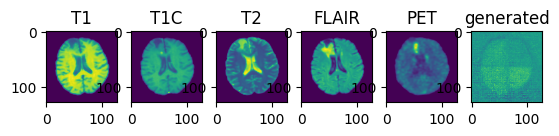

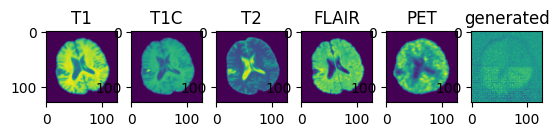

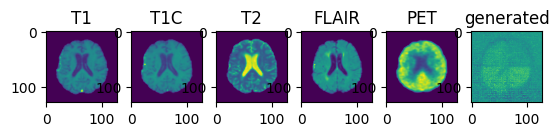

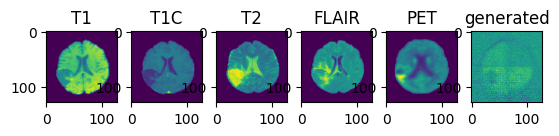

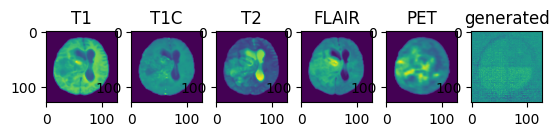

validation avg MS-SSIM: 0.0000
----------
epoch 11/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:30<00:00,  7.51s/it]


----------
epoch 12/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:31<00:00,  7.63s/it]


----------
epoch 13/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:31<00:00,  7.62s/it]


----------
epoch 14/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:31<00:00,  7.59s/it]


----------
epoch 15/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:32<00:00,  7.72s/it]


----------
epoch 16/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:30<00:00,  7.55s/it]


----------
epoch 17/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:30<00:00,  7.55s/it]


----------
epoch 18/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:32<00:00,  7.67s/it]


----------
epoch 19/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:30<00:00,  7.56s/it]


----------
epoch 20/40


Epoch : 100%|███████████████████████████████████| 12/12 [01:30<00:00,  7.57s/it]


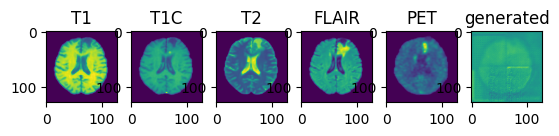

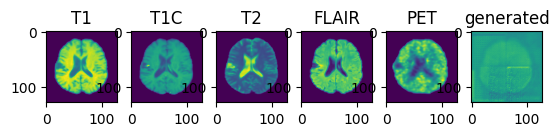

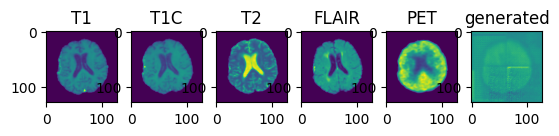

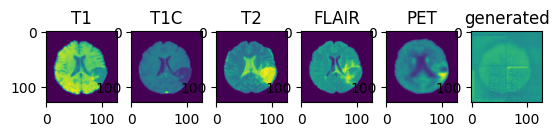

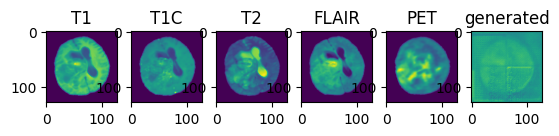

validation avg MS-SSIM: 0.1015
----------
epoch 21/40


Epoch :  58%|█████████████████████               | 7/12 [01:14<00:24,  4.98s/it]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f73f84e69b0>>
Traceback (most recent call last):
  File "/radraid/hassanrizvi/PET-GAN/petgan/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Epoch :  75%|███████████████████████████         | 9/12 [01:24<00:28,  9.34s/it]

KeyboardInterrupt



In [11]:
epoch_loss_values = [(0, 0)]
gen_step_loss = []
disc_step_loss = []
step = 0
max_epochs = 300
disc_train_interval = 1
disc_train_steps = 1
validation_interval = 10
best_ssim = 0
torch.cuda.empty_cache()

for epoch in range(max_epochs):
    gen_net.train()
    disc_net.train()
    epoch_loss = 0

    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    for batch_data in tqdm(train_loader, desc=("Epoch ")):
        input_images = torch.cat((batch_data["t1"].to(device, dtype=torch.float), 
                                 batch_data["t1c"].to(device, dtype=torch.float), 
                                 batch_data["t2"].to(device, dtype=torch.float), 
                                 batch_data["flair"].to(device, dtype=torch.float)), dim=1).to(device)

        real_pet = batch_data["pet"].to(device, dtype=torch.float)
        
        gen_opt.zero_grad()
        gen_images = gen_net(input_images)
        loss = generator_loss(gen_images, real_pet)
        loss.backward()
        gen_opt.step()
        epoch_loss += loss.item()
        
        real_pet = real_pet[:,0,:,:,:]
        gen_images = gen_images[:,0,:,:,:]

        gen_step_loss.append((step, loss.item()))

        if step % disc_train_interval == 0:
            disc_total_loss = 0

            for _ in range(disc_train_steps):
                disc_opt.zero_grad()
                dloss = discriminator_loss(gen_images, real_pet)
                dloss.backward()
                disc_opt.step()
                disc_total_loss += dloss.item()

            disc_step_loss.append((step, disc_total_loss / disc_train_steps))
        step += 1
    
    epoch_loss /= step
    epoch_loss_values.append((step, epoch_loss))

    if (epoch+1) % validation_interval == 0:
        gen_net.eval()
        slice_index = 32
        ms_ssim = []
        ms_ssim_function = monai.metrics.MultiScaleSSIMMetric(spatial_dims = 3, reduction="none", kernel_size=4)
        
        with torch.no_grad():
            for item in valid_loader:
                input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)

                generated = gen_net(input_images)
        
                image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index], generated[0, 0, :, :, slice_index] 
                
                f, axarr = plt.subplots(1, 6)

                ms_ssim.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))
                
                axarr[0].imshow(image_datas[0])
                axarr[0].set_title("T1")
                axarr[1].imshow(image_datas[1])
                axarr[1].set_title("T1C")
                axarr[2].imshow(image_datas[2])
                axarr[2].set_title("T2")
                axarr[3].imshow(image_datas[3])
                axarr[3].set_title("FLAIR")
                axarr[4].imshow(image_datas[4])
                axarr[4].set_title("PET")
                axarr[5].imshow(image_datas[5].cpu())
                axarr[5].set_title("generated")
                plt.show()
                curr_ssim = torch.mean(torch.FloatTensor(ms_ssim))

                if curr_ssim > best_ssim:
                    best_ssim = curr_ssim
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': gen_net.state_dict(),
                        'optimizer_state_dict': gen_opt.state_dict(),
                        }, "best_metric_glagan.pth")
                
        print("validation avg MS-SSIM: {:.4f}".format(curr_ssim))
            

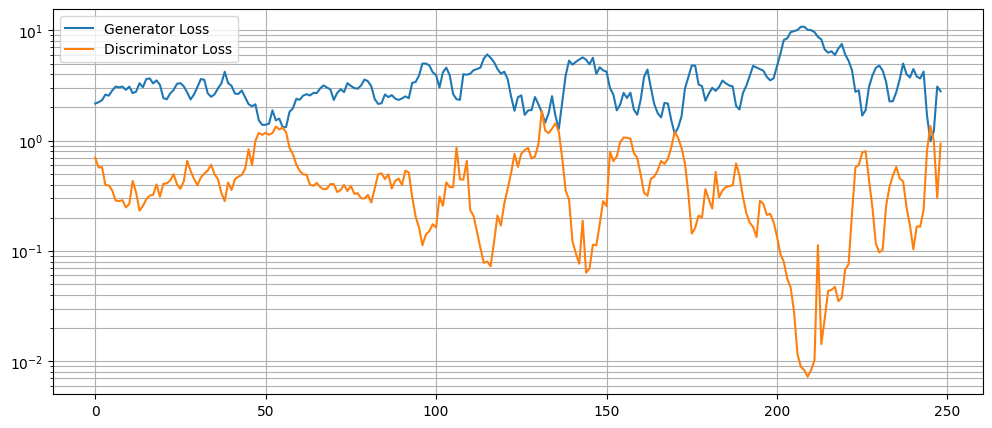

In [12]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*gen_step_loss), label="Generator Loss")
plt.semilogy(*zip(*disc_step_loss), label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()

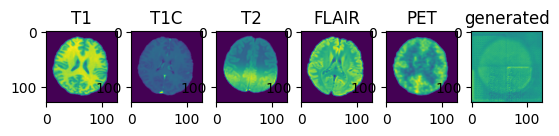

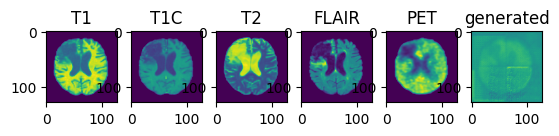

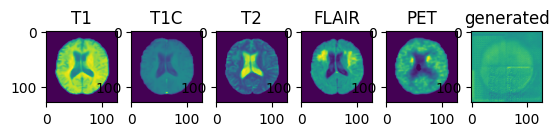

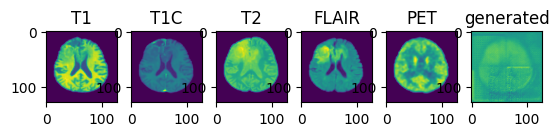

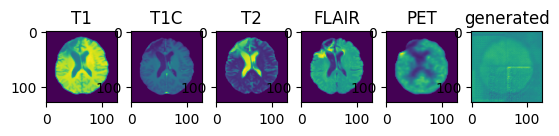

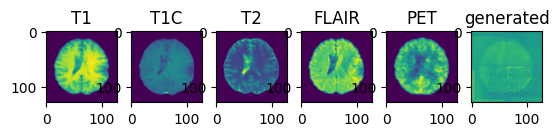

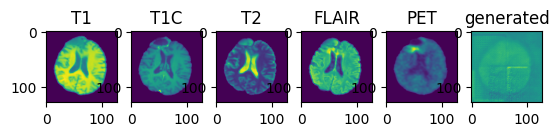

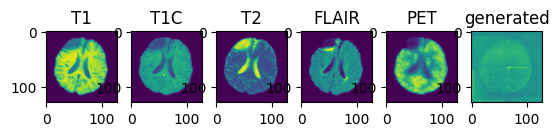

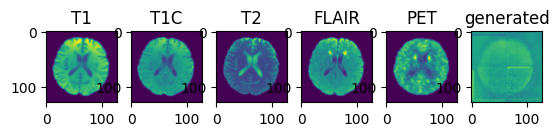

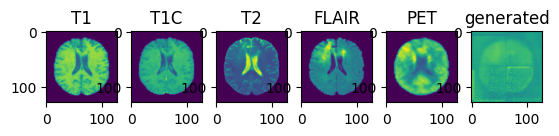

It has been 2444.8136036396027 seconds since the loop started
validation avg MS-SSIM: 0.1525 validation avg MSE 0.0000


In [13]:

slice_index = 32

torch.cuda.empty_cache()

saved_dict = torch.load("best_metric_glagan.pth")
gen_net.load_state_dict(saved_dict['model_state_dict'])
gen_net.eval()

ms_ssim = []
ms_ssim_function = monai.metrics.MultiScaleSSIMMetric(spatial_dims = 3, reduction="none", kernel_size=4)

for item in check_DataLoader:

    with torch.no_grad():
        
        input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)

        generated = gen_net(input_images)
        
        image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index], generated[0, 0, :, :, slice_index] 
                
        f, axarr = plt.subplots(1, 6)

        ms_ssim.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))
                
        axarr[0].imshow(image_datas[0])
        axarr[0].set_title("T1")
        axarr[1].imshow(image_datas[1])
        axarr[1].set_title("T1C")
        axarr[2].imshow(image_datas[2])
        axarr[2].set_title("T2")
        axarr[3].imshow(image_datas[3])
        axarr[3].set_title("FLAIR")
        axarr[4].imshow(image_datas[4])
        axarr[4].set_title("PET")
        axarr[5].imshow(image_datas[5].cpu())
        axarr[5].set_title("generated")
        plt.show()


now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

print("validation avg MS-SSIM: {:.4f} validation avg MSE {:.4f}".format(torch.mean(torch.FloatTensor(ms_ssim)), 0))